## Re-analyze Karp et al. (2105) data
### P.B. Stark

Python 3 notebook

In [1]:
%matplotlib inline
import math
import numpy as np
import scipy as sp
from scipy.stats import binom, chi2, hypergeom
import numbers
import matplotlib.pyplot as plt
import csv
import re
import pandas as pd
import itertools
import permute as pt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from permute.utils import binom_conf_interval
from cryptorandom import cryptorandom as cr
from cryptorandom import sample

seed = "statistics 159/259 fall 2018"
prng = cr.SHA256(seed)

In [2]:
fn = '../Data/karp_farms.csv'
with open(fn, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    farms = [r for r in reader]

In [3]:
# what are the column names?
farms[0].keys()

odict_keys(['Farm ID', 'county', 'town', 'E_Coli_Change', 'Salm_Change', 'Change in Nature', 'Change in Riparian', 'Change in Crop'])

In [4]:
ecoli = np.array([float(f['E_Coli_Change']) for f in farms])     # the change in E coli 
nature = np.array([float(f['Change in Nature']) for f in farms]) # the change in natural vegetation

# values for regression line plot
nature_line = np.linspace(np.amin(nature), np.amax(nature), num=100)

# augment data with a vector of 1s for regression with an intercept
nature1 = sm.add_constant(nature)  

In [5]:
np.min(ecoli)

-0.003921569

In [6]:
def do_regress(y, x):
    regress = sm.OLS(y, x).fit()  # fit the linear regression model using OLS
    print(regress.summary())
    coeffs = regress.params                 # coeffs[0] is the intercept; coeffs[1] is the slope
    plt.scatter(x[:,1], y,  color='blue')                   # data
    plt.plot(nature_line, coeffs[0] + coeffs[1] * nature_line)  # regression line
    plt.xlabel('Relative change in natural vegetation')
    plt.ylabel('Relative change in EHEC')
    plt.show()
    return(coeffs)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     11.08
Date:                Sun, 16 Sep 2018   Prob (F-statistic):            0.00262
Time:                        20:37:19   Log-Likelihood:                 57.716
No. Observations:                  28   AIC:                            -111.4
Df Residuals:                      26   BIC:                            -108.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.007      0.492      0.6

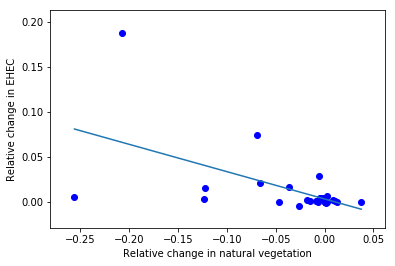

In [7]:
coeffs= do_regress(ecoli, nature1)

Look at the coefficient lines in the regression output:

>     ==============================================================================
>                    coef    std err          t      P>|t|      [0.025      0.975]
>     ------------------------------------------------------------------------------
>     const          0.0033      0.007      0.492      0.627      -0.011       0.017
>     x1            -0.3036      0.091     -3.328      0.003      -0.491      -0.116

We are interested in the slope, x1, which is summarized in the bottom row.

The least-squares estimate of x1 is coef=-0.3036. 
This value can be calculated provided the design matrix $X$ has full rank (so that $X^TX$ is invertible). 
The estimate is unbiased if the model $Y = X\beta + \epsilon$ is true, with $\mathbb{E} \epsilon = 0$.

The standard error 0.091 can be calculated provided $X$ has full rank and $n > p$ (the number of data is greater than the number of parameters). But it is "really" an estimate of the standard error of the estimated slope only if the model is true, $X$ is full rank, $n > p$, $\mathbb{E}\epsilon = 0$, and $\mathrm{cov} \epsilon = \sigma^2 I_{n}$.

The t statistic -3.328 can be computed whenever coef and std err can be computed.
But the p-value, P>|t|, is correct only if the model is true, $X$ has full rank, $n > p$, and $\epsilon \sim N(0, \sigma^2 I_n)$. 
The same is true for the confidence interval.

## Significance of the slope

### Standard regression model

The "usual" regression model says $Y = X\beta + \epsilon$, where 

\begin{equation*}  X = \left [ \begin{array}{ccccc} X_{11} & X_{12} & \cdots & X_{1p} \\ 
                X_{21} & X_{22} & \cdots & X_{2p} \\
                \vdots & \vdots & \vdots & \vdots \\ 
                X_{n1} & X_{n2} & \cdots & X_{np} \end{array} \right ]\end{equation*}

is the _design matrix_, $\beta = [\beta_1 \beta_2 \cdots \beta_p]^T$ are the _coefficients_, $\epsilon = [\epsilon_1 , \ldots, \epsilon_n]^T$ is the _noise_ or _random error_, and it is assumed that
$\{ \epsilon_j \}_{j=1}^n$ are IID with mean zero and variance $\sigma^2$.
We assume that $X$ is full rank $p$ and either that $X$ is not random or that $X$ and $\epsilon$ are independent, in which case we will condition on $X$. 
We also assume $n > p$.

The OLS estimate is $\hat{\beta} \equiv (X^TX)^{-1}X^T Y$.

#### Theorem: the OLS estimate is unbiased and $\mathrm{cov}(\hat{\beta}) = (X^TX)^{-1} X^T \mathrm{cov}(\epsilon | X) X (X^TX)^{-1}$.

**Proof.** 

\begin{equation*}  (X^TX)^{-1}X^T Y = (X^TX)^{-1}X^T (X\beta + \epsilon) = (X^TX)^{-1}X^TX\beta + (X^TX)^{-1}X^T\epsilon \end{equation*}

\begin{equation*}  = \beta + (X^TX)^{-1}X^T\epsilon.\end{equation*}

Now, 

\begin{equation*} \mathbb{E} \left (\beta + (X^TX)^{-1}X^T\epsilon | X \right ) = \beta + (X^TX)^{-1}X^T \mathbb{E} (\epsilon | X)\end{equation*}

\begin{equation*}  = \beta + (X^TX)^{-1}X^T \mathbf{0} = \beta,\end{equation*}

so $\hat{\beta}$ is unbiased.

\begin{equation*}  \mathrm{cov} \left (\hat{\beta} | X \right ) \equiv \mathbb{E} ((\hat{\beta} - \beta)(\hat{\beta} - \beta)^T | X) \end{equation*}

\begin{equation*}  = \mathbb{E} \left ( (X^TX)^{-1}X^T \epsilon ((X^TX)^{-1}X^T \epsilon)^T | X \right ) \end{equation*}

\begin{equation*}  = \mathbb{E} \left ( (X^TX)^{-1}X^T \epsilon \epsilon^T X (X^TX)^{-1} | X \right ) \end{equation*}

\begin{equation*}  = (X^TX)^{-1}X^T \mathbb{E}(\epsilon \epsilon^T | X) X (X^TX)^{-1}\end{equation*}

\begin{equation*}  = (X^TX)^{-1}X^T \mathrm{cov}(\epsilon | X) X (X^TX)^{-1}.\end{equation*}

Since $\mathrm{cov}(\epsilon | X) = \sigma^2 I_{n}$, this simplifies to

\begin{equation*}  \mathrm{cov} (\hat{\beta} | X) = \sigma^2 (X^TX)^{-1}X^T I_n X (X^TX)^{-1} = \sigma^2 (X^TX)^{-1}.\end{equation*}

Define $e = Y - X \hat{\beta}$, the _residuals_.

A conditionally unbiased estimate for $\sigma^2$ is 

\begin{equation*}  \hat{\sigma}^2 = \frac{1}{n-p} \sum_{j=1}^n e_j^2 = \frac{1}{n-p} \sum_{j=1}^n (Y_j - X_j \hat{\beta})^2.\end{equation*}

#### The t-test

The $t$-test for whether a coefficient is significantly different from zero requires the further assumption that
$\{ \epsilon_j \}$ have a distribution that is jointly normal (given $X$):  given $X$, $\{ \epsilon_j \}$ are IID $N(0, \sigma^2)$.

Then $\hat{\beta} \sim N(\beta, \sigma^2 (X^TX)^{-1})$.

The $t$ statistic for the $\hat{\beta}_k$ is 

\begin{equation*}  t = \hat{\beta}_k/\hat{\mathrm{SE}}_k, \end{equation*}

where $\hat{\mathrm{SE}}_k \equiv \hat{\sigma} \sqrt{(X^TX)^{-1}_{kk}}$.

Under all the assumptions, $t$ has Student's $t$ distribution with $n-p$ degrees of freedom if $\beta_k = 0$.

### Permutation test

Because the assumptions that lead to the t-test are unreasonable in this application, we will look at other ways of assessing the evidence that the two variables are associated.

Let's specialize to the case $p = 2$, with $X_{k1} = 1$ (an intercept term in the regression).

Suppose that the components of $\epsilon$ are IID (but not necessarily zero mean, normal, or anything else). Under the hypothesis that $\beta_1 = 0$, the data are then

\begin{equation*}  Y_j = \beta_0 + 0\times X_j + \epsilon_j = \beta_0 + \epsilon_j, \;\; j=1, \ldots, n.\end{equation*}

Since $\{ \epsilon_j \}$ are IID, so are $\{ Y_j = \beta_0 + \epsilon_j \}$.

__Definition.__ A set of random variables $\{Z_j \}_{j=1}^n$ is _exchangeable_ if the joint distribution of $(Z_{\pi_1}, Z_{\pi_2}, \ldots, Z_{\pi_n})$ is the same for all permutations $\pi$ of $\{1, 2, \ldots, n\}$.

If a set of variables is IID, it is exchangeable. (The converse is not necessarily true.)

Thus if $\beta_1 = 0$, $\{Y_j \}_{j=1}^n$ are exchangeable.

Suppose $\{Z_j \}_{j=1}^n$ are exchangeable, and let $z \in \Re^n$. 
Then for every permutation $\pi$ of $\{1, \ldots, n \}$,

\begin{equation*} \Pr \{ Z_j = z_j, j=1, \ldots, n \} = \Pr \{ Z_j = z_{\pi_j}, j = 1, \ldots, n \}.\end{equation*}

Let $z = (z_1, \ldots, z_n)$.
The set of all $(z_{\pi_j})_{j=1}^n$ for all permutations $\pi$ of $\{1, \ldots, n \}$ is _the orbit of $z$ under the permutation group_.

#### What's the justification for *this* model here?

Why linear? Why additive errors? Why IID errors?

#### Another approach: the Neyman "ticket" model

| item | response if assigned $X_1$ | $\cdots$ | response if assigned $X_n$ |
|:----:|:--------------------------:|:--------:|:--------------------------:|
| 1    |  $Y_{11}$                  | $\cdots$ | $Y_{1n}$                  |
|  $\vdots$ | $\vdots$              | $\vdots$ |  $\vdots$                 |
| $n$  |  $Y_{n1}$                  | $\cdots$ | $Y_{nn}$                  |

Suppose there's no connection between $X$ and $Y$: response of item $j$ would be the same, regardless of
the value of $X_i$.
Then all "shufflings" of $Y$ versus $X$ would be equally likely;
treat the data as if the treatment were assigned at random to the farm.

Is that more plausible or less plausible than the regression models?

Leads to exactly the same permutation test as $Y = X\beta + \epsilon$ with 
the components of $\epsilon$ IID.

Why use $|\hat{\beta}_1|$ as the test statistic?

Equivalent to a permutation test based on the Pearson correlation:

$\hat{\beta}_1 = r \mathrm{SD}(Y)/\mathrm{SD}(X)$, where $r$ is the (sample) correlation between $X$ and $Y$.

One-to-one, monotonic relationship between them, so reject the null for exactly the
same data sets.

## How to shuffle

1. Assign a pseudo-random number to every element, then sort based on that number

1. Fisher-Yates-Knuth-Durstenfeld shuffle

**Algorithm Fisher-Yates-Knuth-Durstenfeld shuffle (backwards version)**

    for i=1, ..., n-1:
        J <- random integer uniformly distributed on {i, ..., n}
        (a[J], a[i]) <- (a[i], a[J])
        
This requires the ability to generate independent random integers on various ranges. Doesn't require sorting.

There's a version suitable for streaming, i.e., generating a random permutation of a list that has an (initially) unknown number  nn of elements:

**Algorithm Fisher-Yates-Knuth-Durstenfeld shuffle (streaming version)**

    i <- 0
    a = []
    while there are records left:
        i <- i+1
        J <- random integer uniformly distributed on {1, ..., i}
        if J < i:
            a[i] <- a[J]
            a[J] <- next record
        else:
            a[i] <- next record

Again, need to be able to generate independent uniformly distributed random integers.

In [8]:
def fykd(a, gen=np.random):
    for i in range(len(a)-1):
        J = gen.randint(i,len(a))
        a[i], a[J] = a[J], a[i]
    return(a)

### Proof that the streaming Fisher-Yates-Knuth-Durstenfeld algorithm works

Induction: 

For $i=1$, obvious.

At stage $i$, suppose all $i!$ permutations are equally likely. For each such permutation, there are
$i+1$ distinct, equally likely permutations at stage $i+1$, resulting from swapping the $i+1$st item with one
of the first $i$, or putting it in position $i+1$. These possibilities are mutually exclusive of
the permutations attainable from a different permutation of the first $i$ items.

Thus, this enumerates all $(i+1)i! = (i+1)!$ permutations of $(i+1)$ items, and they are equally likely. &#x25A0;

## How not to shuffle

Sort using a "random" comparison function, e.g.,

    def RandomSort(a,b):
        return (0.5 - np.random.random())

But this fails the basic properties of an ordering, e.g., transitivity, reflexiveness, etc. Doesn't produce random permutation. Output also depends on sorting algorithm. 

Notoriously used by Microsoft to offer a selection of browsers in the EU. Resulted in IE being 5th of 5 about half the time in IE and about 26% of the time in Chrome, but only 6% of the time in Safari (4th about 40% of the time).

See, e.g., http://www.computerworld.com/article/2520190/web-apps/microsoft-s-eu-ballot-fails-to-randomize-browser-order.html

## How to generate random integers

Textbook approach:

To generate a random integer between 0 and m-1

* Generate $U \sim U[0, 1)$
* Return $\lfloor mU \rfloor$

Works if $U$ _really were_ $U[0, 1)$, but that's not what PRNGs generate. Instead, typically generate a $k$-bit binary fraction (or its floating-point representation).

Introduces truncation effects. Even if the PRNG were perfectly uniform on its output, result would be uniformly distributed on $\{0, 1, \ldots, m-1\}$ only if $m$ is a power of 2 (not exceeding the number of bits of output of the PRNG).

Better approach (used in python):

Let $k = \lceil \log_2(m-1) \rceil$. Generate $k$ random bits and interpret the result $M$ as an integer. If $M \le m-1$, return $M$. Otherwise, generate $k$ more random bits and try again.

See [cryptorandom](https://github.com/statlab/cryptorandom/blob/master/cryptorandom/cryptorandom.py)

### How R generates random integers

R uses a variant of the floor approach, but uses floating-point numbers at an intermediate step. 

In [9]:
# Use cryptorandom's permutation
def permute_regress(ec, nat, reps=int(10**5)):
    '''
    Permutation distribution of OLS estimate of slope, regressing ec on nat
    '''
    vals = np.zeros(reps)                                         # allocate storage for slope estimates
    for i in range(reps):
        permutation = np.array(sample.fykd_sample(len(ec), len(ec), gen=prng))-1  # shuffle indices
        p_ec = ec[permutation]                                    # permute the E coli values
        vals[i] = sm.OLS(p_ec, nat).fit().params[1]               # regress
    return vals

def p_CI(v,t): 
    '''
    estimated probability that |v| >= t based on independent trials,
    and upper confidence bound for the true probability
    '''
    exceed = sum(abs(v) >= t)
    print("estimated p:", exceed/len(v), binom_conf_interval(n=len(v),x=exceed, alternative='upper'))

In [10]:
vals = permute_regress(ecoli, nature1)
p_CI(vals, abs(coeffs[1]))

estimated p: 0.03099 (0.0, 0.032082742274273775)


## Sensitivity to farm 31

In [11]:
ecoli_edit = np.array([float(f['E_Coli_Change']) for f in farms if f['Farm ID'] != '31'])     # omit farm 31
nature_edit = np.array([float(f['Change in Nature']) for f in farms if f['Farm ID'] != '31']) # omit farm 31
nature_edit1 = sm.add_constant(nature_edit)    # add intercept

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.562
Date:                Sun, 16 Sep 2018   Prob (F-statistic):              0.223
Time:                        20:37:57   Log-Likelihood:                 75.457
No. Observations:                  27   AIC:                            -146.9
Df Residuals:                      25   BIC:                            -144.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.003      1.645      0.1

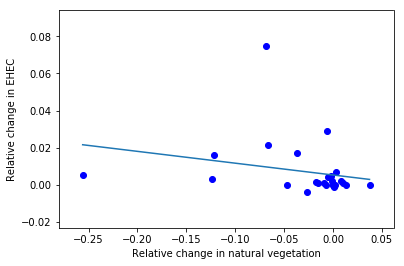

estimated p: 0.11594 (0.0, 0.11794043933579963)


In [12]:
coeffs_edit = do_regress(ecoli_edit, nature_edit1)
vals = permute_regress(ecoli_edit, nature_edit1) # permutation distribution of estimated slope
p_CI(vals, abs(coeffs_edit[1]))

## Fourth-root transformation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     8.873
Date:                Sun, 16 Sep 2018   Prob (F-statistic):            0.00620
Time:                        20:38:39   Log-Likelihood:                 9.3891
No. Observations:                  28   AIC:                            -14.78
Df Residuals:                      26   BIC:                            -12.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1275      0.038      3.348      0.0

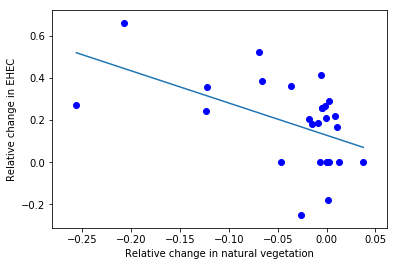

In [13]:
# Karp et al. use fourth-root transformation of the contamination data.

ecoli4th = np.multiply(np.sign(ecoli), np.power(np.abs(ecoli), 1/4))   # signed fourth root
coeffs4th = do_regress(ecoli4th, nature1)                              # reference estimates

In [14]:
# simulated p-value
vals = permute_regress(ecoli4th, nature1) # permutation distribution of estimated slope
p_CI(vals, abs(coeffs4th[1])) 

estimated p: 0.00672 (0.0, 0.007245947095395319)


### 4th root without farm 31

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     3.599
Date:                Sun, 16 Sep 2018   Prob (F-statistic):             0.0694
Time:                        20:39:20   Log-Likelihood:                 9.6339
No. Observations:                  27   AIC:                            -15.27
Df Residuals:                      25   BIC:                            -12.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1311      0.037      3.504      0.0

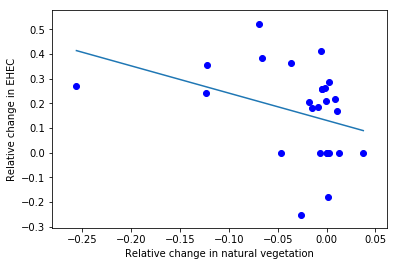

In [15]:
# Sensitivity to farm 31
ecoli4th_edit = np.array([float(f['E_Coli_Change']) for f in farms if f['Farm ID'] != '31']) # omit farm 31
ecoli4th_edit = np.multiply(np.sign(ecoli4th_edit), np.power(np.abs(ecoli4th_edit), 1/4))    # signed 4th root
coeffs4th_edit = do_regress(ecoli4th_edit, nature_edit1)           # reference coefficients

In [16]:
# simulated p-value
vals = permute_regress(ecoli4th_edit, nature_edit1)  # permutation distribution of estimated slope
p_CI(vals, abs(coeffs4th_edit[1]))

estimated p: 0.06815 (0.0, 0.0697294654933772)


## Questions:

1. How did Karp et al. decide to use the 4th-root transformation?

1. What is the effect of using that transformation?

1. How many other transformations were considered or tried? Does the article say? 

1. What effect does testing for normality and trying different transformations have on the p-value?

Gelman and Loken, 2013: ["Garden of Forking Paths"](http://www.stat.columbia.edu/~gelman/research/unpublished/p_hacking.pdf)

## Technical issues:

1. Formally, $\hat{\beta} = (X^TX)^{-1}X^TY$, but that's not how to compute it. Why?

In [17]:
%load_ext version_information
%version_information scipy, numpy, pandas, matplotlib, notebook, jupyter

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


/anaconda/lib/python3.6/site-packages/IPython/core/formatters.py:839: FormatterWarning: JSON expects JSONable list/dict containers, not JSON strings
  FormatterWarning)


Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.4.0
OS Darwin 17.7.0 x86_64 i386 64bit
scipy 1.1.0
numpy 1.14.5
pandas 0.23.1
matplotlib 2.2.2
notebook 5.5.0
jupyter 1.0.0
Sun Sep 16 20:40:01 2018 PDT